# PREDICTING STANDINGS OF THE FORMULA 1 DRIVER'S CHAMPIONSHIP

**Group Members:** Dmitry Sorokin, Justin Shiu, Kyle Chahal, Justin An

# Phase 2: Project Outline

For our project, we decided to try and predict the standings of the Driver’s Championship in Formula 1 (F1). Our data set consists of F1 race results, drivers, and teams from the 2019-2024 seasons. Our goal is to use the driver’s team, their number of podium finishes, their fastest laps for races, their finishing position and starting position, and their podium percentage to determine their final Driver’s Championship ranking. Furthermore, we plan to use a model to partition the drivers into 3 different tiers: lower tier, middle tier, and high tier drivers. This is to see the caliber of drivers that each team and country has. 


# Features in the Dataset

## All_drivers Variables:
- **Number** - A driver’s personal identifying number, unique to each driver
- **Team** - The team that the driver races for
- **Country** - The country where the driver originates from
- **Podiums** - The number of podiums that a driver has achieved for the season. A podium is classified as achieving first, second, or third place in a race.
- **Points** - The total number of points that a driver has accumulated in their career. Points are awarded to the top 10 places in a Grand Prix, with 1st place receiving 25 points and decreasing to 10th place receiving 1 point.
- **Grand Prix Entered** - The number of races that a driver has participated in during a season.
- **World Championships** - The number of World Championships a driver has won.
- **Highest Grid Position** - The highest starting position that a driver is granted in a race.
- **Podium Percentage** - A percentage calculated as podiums divided by Grand Prix entered.
- **Has WC** - This is a binary variable. `1` is granted to drivers who have won a world championship, while `0` is granted to those who have not.

## All_races Variables:
- **Track** - The location of the race.
- **Position** - The final placement of the driver in this race.
- **No** - A driver’s personal identifying number, unique to each driver.
- **Team** - The team that the driver races for.
- **Starting Grid** - The starting position of the driver in this race.
- **Points** - Number of points accumulated by a driver in this race.
- **Year** - The year of the race.
- **Net Position** - The difference between a driver's starting grid position and final position for this race.
- **Time (seconds)** - The recorded time to complete the race.

## Standings Variables:
- **Year** - The year of the season.
- **Number** - A driver’s personal identifying number, unique to each driver.
- **Position** - The place the driver finished in at the end of the season, in terms of total points.
- **Points** - Total points earned by a driver in that season.


**Slides Link**
https://docs.google.com/presentation/d/1Dpz5lbLk-aITkDaxrO2_3_PTt-GS_-aODBaSxiGjrAE/edit?usp=sharing

Adding Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import re

import warnings
warnings.simplefilter("ignore")


Getting the Data frames ready:

Creating a dataframe that contians all of the information on the drivers across years

In [2]:
drivers_2019 = pd.read_csv("Data/2019_drivers.csv")
drivers_2019["Year"] = 2019
drivers_2020 = pd.read_csv("Data/2020_drivers.csv")
drivers_2020["Year"] = 2020
drivers_2021 = pd.read_csv("Data/2021_drivers.csv")
drivers_2021["Year"] = 2021
drivers_2022 = pd.read_csv("Data/2022_drivers.csv")
drivers_2022["Year"] = 2022
drivers_2023 = pd.read_csv("Data/2023_drivers.csv")
drivers_2023["Year"] = 2023
drivers_2024 = pd.read_csv("Data/2024_drivers.csv")
drivers_2024["Year"] = 2024

all_drivers = pd.concat([drivers_2019, drivers_2020, drivers_2021, drivers_2022, drivers_2023, drivers_2024], axis = 0)

all_drivers
all_drivers.drop(columns=["Driver", "Highest Race Finish",  "Date of Birth", "Place of Birth", "Abbreviation"],inplace = True)
all_drivers


all_drivers["Number"] = all_drivers["Number"].fillna(all_drivers["No"])
all_drivers
all_drivers.drop(columns=["No"],inplace = True)


all_drivers["Podium Percentage"] = all_drivers["Podiums"] / all_drivers["Grands Prix Entered"]
all_drivers.head()

all_drivers["Has WC"] = np.where(all_drivers["World Championships"] > 0, 1, 0)
all_drivers.head()

,Number,Team,Country,Podiums,Points,Grands Prix Entered,World Championships,Highest Grid Position,Year,Podium Percentage,Has WC
0,44.0,Mercedes,United Kingdom,151,3431.0,250,6,1,2019,0.604000,1
1,77.0,Mercedes,Finland,45,1289.0,140,0,1,2019,0.321429,0
2,33.0,Red Bull Racing,Netherlands,31,948.0,102,0,1,2019,0.303922,0
3,16.0,Ferrari,Monaco,10,303.0,42,0,1,2019,0.238095,0
4,5.0,Ferrari,Germany,120,2985.0,241,4,1,2019,0.497925,1


Now we will create a Data Frame that contains wanted information on all of the races across the years

In [3]:
raceRes19 = pd.read_csv("Data/2019_raceResults.csv")
raceRes19["Year"] = 2019
raceRes20 = pd.read_csv("Data/2020_raceResults.csv")
raceRes20["Year"] = 2020
raceRes21 = pd.read_csv("Data/2021_raceResults.csv")
raceRes21["Year"] = 2021
raceRes22 = pd.read_csv("Data/2022_raceResults.csv")
raceRes22["Year"] = 2022
raceRes23 = pd.read_csv("Data/2023_raceResults.csv")
raceRes23["Year"] = 2023
raceRes24 = pd.read_csv("Data/2024_raceResults.csv")
raceRes24["Year"] = 2024

#finding all of the unique races in 2021
unique_races_21 = raceRes21["Track"].unique()

#setting the fastest lap of those who did not complete a lap 100 minutes to make sure they do not count 
raceRes21["Fastest Lap"] = raceRes21["Fastest Lap"].fillna("100:0.0")
#creating a new variable called "Set Fastest Lap" and setting it by default to "No"
raceRes21["Set Fastest Lap"] = "No"

#Making a functrion that will take the string time that a driver set for their fastest lap and returning it in milliseconds 
def time_to_sec(time):
    # Split into minutes and "seconds.milliseconds"
    minutes, sec_millis = time.split(":")  
    # Split seconds and milliseconds
    seconds, milliseconds = sec_millis.split(".")  
        
    # Convert all parts to integers
    total_ms = (int(minutes) * 60 + int(seconds)) * 1000 + int(milliseconds)

    #returning the total miliseconds 
    return total_ms

#for each track in the 2021 season we find the minimum time, aka the fastest lap and we check it with all of the lap times and set "Set Fastest Lap" to "Yes" or "No"
for i in range(0,len(unique_races_21)):
    track_subset = raceRes21[raceRes21["Track"] == unique_races_21[i]]
    #finding minimum value 
    fastest_time = min(track_subset['Fastest Lap'])

    #setting Yes or No to each track for "Set fastest Lap"
    raceRes21.loc[raceRes21["Track"] == unique_races_21[i], "Set Fastest Lap"] = raceRes21.loc[raceRes21["Track"] == unique_races_21[i], "Fastest Lap"].apply(lambda x: "Yes" if x == fastest_time else "No")


#repeating the process as we did for 2021, but for the 2022 season
raceRes22["Fastest Lap"] = raceRes22["Fastest Lap"].fillna("100:0.0")
raceRes22["Set Fastest Lap"] = "No"

#finding all of the unique races in 2021
unique_races_22 = raceRes22["Track"].unique()

#for each track in the 2021 season we find the minimum time, aka the fastest lap and we check it with all of the lap times and set "Set Fastest Lap" to "Yes" or "No"
for i in range(0,len(unique_races_22)):
    track_subset = raceRes21[raceRes22["Track"] == unique_races_22[i]]
    fastest_time = min(track_subset['Fastest Lap'])

    #setting Yes or No to each track for "Set fastest Lap"
    raceRes22.loc[raceRes22["Track"] == unique_races_22[i], "Set Fastest Lap"] = raceRes22.loc[raceRes22["Track"] == unique_races_22[i], "Fastest Lap"].apply(lambda x: "Yes" if x == fastest_time else "No")


#Setting the fastest lap column to equal the set fastest lap column, as we won't use it in the future
raceRes21["Fastest Lap"] = raceRes21["Set Fastest Lap"]
raceRes22["Fastest Lap"] = raceRes22["Set Fastest Lap"]


#Concatenating all of the different datasets we have for our races
all_races = pd.concat([raceRes19, raceRes20, raceRes21, raceRes22, raceRes23, raceRes24], axis = 0)


#need to merge total time/gap with time/req & need to merge fastest lap with set fastest lap
all_races["Time/Retired"] = all_races["Time/Retired"].fillna(all_races["Total Time/Gap/Retirement"])
all_races["Fastest Lap"] = all_races["Fastest Lap"].fillna(all_races["Set Fastest Lap"])

all_races.drop(columns = ["Driver", "Laps", "Total Time/Gap/Retirement", "Set Fastest Lap", "+1 Pt", "Fastest Lap Time"], inplace = True)

all_races = all_races[(all_races["Position"] != "DQ") & (all_races["Position"] != "NC")]
all_races = all_races.dropna()

all_races["Position"] = all_races["Position"].astype(int)
all_races["Starting Grid"] = all_races["Starting Grid"].astype(int)

all_races["Net Position"] = all_races["Starting Grid"] - all_races["Position"]

all_races.head()



,Track,Position,No,Team,Starting Grid,Points,Fastest Lap,Year,Time/Retired,Net Position
0,Australia,1,77,Mercedes,2,26.0,Yes,2019,1:25:27.325,1
1,Australia,2,44,Mercedes,1,18.0,No,2019,+20.886,-1
2,Australia,3,33,Red Bull Racing Honda,4,15.0,No,2019,+22.520,1
3,Australia,4,5,Ferrari,3,12.0,No,2019,+57.109,-1
4,Australia,5,16,Ferrari,5,10.0,No,2019,+58.230,0


Since we do not have uniform time for our 'Time/Retired' variable, we will convert the race times to all be in seconds. 

For each time required that has a value of + X number of laps, we add X * 90 seconds to the fastest time. We chose 90 seconds because that is around the average time it takes for a driver to complete a lap on any circuit.

In [4]:
def time_to_seconds(time_str):
    """Convert race time formats to absolute seconds."""
    if isinstance(time_str, str):
        if re.match(r'^\d{1,2}:\d{2}:\d{2}\.\d{3}$', time_str):  # hh:mm:ss.sss
            h, m, s = map(float, time_str.split(':'))
            return h * 3600 + m * 60 + s
        elif re.match(r'^\d{1,2}:\d{2}\.\d{3}$', time_str):  # mm:ss.sss
            m, s = map(float, time_str.split(':'))
            return m * 60 + s
    return None  # If not a valid time format, return None

def convert_time_column(all_races):
    """Convert all times to absolute seconds."""
    all_races = all_races.copy()

    # Identify the first-place finisher’s time
    first_place_row = all_races[all_races['Position'] == 1]
    if first_place_row.empty:
        raise ValueError("No first-place finisher found in dataset.")

    first_place_time_str = first_place_row.iloc[0]['Time/Retired']
    first_place_time = time_to_seconds(first_place_time_str)

    if first_place_time is None:
        raise ValueError("Invalid format for first-place finisher’s time.")

    def get_absolute_time(time_str):
    #"""Convert each row's time to absolute seconds."""
        if isinstance(time_str, str):
            if time_str.startswith('+') and 'lap' not in time_str:  # Time gaps (+XX.XXX)
                return first_place_time + float(time_str[1:])
            elif 'lap' in time_str:  # Lap deficits (+N laps)
                avg_lap_time = 90  # Adjust based on track or calculate from data
                laps = int(re.search(r'\d+', time_str).group())  # Extract number of laps
                return first_place_time + (laps * avg_lap_time)
            else:  # Direct race times (hh:mm:ss.sss or mm:ss.sss)
                return time_to_seconds(time_str)

        return None  # Handle unexpected cases


    # Apply conversion
    all_races['Time (seconds)'] = all_races['Time/Retired'].apply(get_absolute_time)

    return all_races

# Apply function and save results
all_races = convert_time_column(all_races)

# Show preview
all_races.head(n = 100)


,Track,Position,No,Team,Starting Grid,Points,Fastest Lap,Year,Time/Retired,Net Position,Time (seconds)
0,Australia,1,77,Mercedes,2,26.0,Yes,2019,1:25:27.325,1,5127.325
1,Australia,2,44,Mercedes,1,18.0,No,2019,+20.886,-1,5148.211
2,Australia,3,33,Red Bull Racing Honda,4,15.0,No,2019,+22.520,1,5149.845
3,Australia,4,5,Ferrari,3,12.0,No,2019,+57.109,-1,5184.434
4,Australia,5,16,Ferrari,5,10.0,No,2019,+58.230,0,5185.555
...,...,...,...,...,...,...,...,...,...,...,...
107,Monaco,8,23,Scuderia Toro Rosso Honda,10,4.0,No,2019,+55.200,2,5182.525
108,Monaco,9,3,Renault,6,2.0,No,2019,+60.894,-3,5188.219
109,Monaco,10,8,Haas Ferrari,13,1.0,No,2019,+61.034,3,5188.359
110,Monaco,11,4,McLaren Renault,12,0.0,No,2019,+66.801,1,5194.126


The output above shows our complete and modified 'all_races' data frame.

Let's also import in a csv that has the driver standings by year.

In [5]:
standings = pd.read_csv("Data/standings.csv")

No modifications were required as the data was clean when we imported it.

**EDA**

In [6]:
standings.head()

,Year,Position,Number,Points
0,2019,1,44,413.0
1,2019,2,77,326.0
2,2019,3,33,278.0
3,2019,4,16,264.0
4,2019,5,5,240.0


To perform EDA we have created a merged data frame between the standings data frame and the all_drivers data frame.

In [7]:
merged_drivers_standings = pd.merge(all_drivers, standings, on=['Number', 'Year'], suffixes=('_driverTotal', '_forSeason'))
merged_drivers_standings.head()

,Number,Team,Country,Podiums,Points_driverTotal,Grands Prix Entered,World Championships,Highest Grid Position,Year,Podium Percentage,Has WC,Position,Points_forSeason
0,44.0,Mercedes,United Kingdom,151,3431.0,250,6,1,2019,0.604000,1,1,413.0
1,77.0,Mercedes,Finland,45,1289.0,140,0,1,2019,0.321429,0,2,326.0
2,33.0,Red Bull Racing,Netherlands,31,948.0,102,0,1,2019,0.303922,0,3,278.0
3,16.0,Ferrari,Monaco,10,303.0,42,0,1,2019,0.238095,0,4,264.0
4,5.0,Ferrari,Germany,120,2985.0,241,4,1,2019,0.497925,1,5,240.0


Now that we have our data cleaned and processed, we want to explore it and see what we can find.

To start, we were wondering if there would be any point difference between teams that have won a world championship vs teams who have not won a world championship.

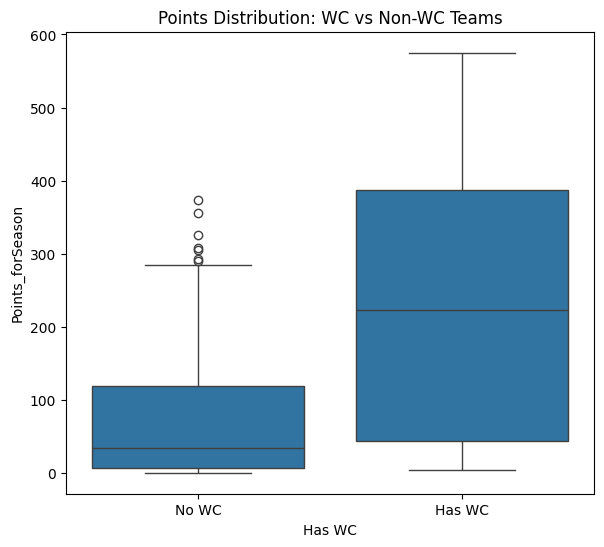

In [8]:
plt.figure(figsize=(15, 6))

# Points comparison
plt.subplot(1, 2, 1)
sns.boxplot(x='Has WC', y='Points_forSeason', data=merged_drivers_standings)
plt.xticks([0, 1], ['No WC', 'Has WC'])
plt.title('Points Distribution: WC vs Non-WC Teams')

plt.show()


We can see here that generally those who have won world championships tend to have earned more points for the season. However, there are some instances where teams who haven't won a world championship have scored higher than those who have one a world championship which is demostrated by the outliers in the no world championship plot. We observe that many of these outliers for non world champions fall above the median points for world champions.

Next we were interested to see if there is any relationship between podium percentage and if a team has won a world championship or not.

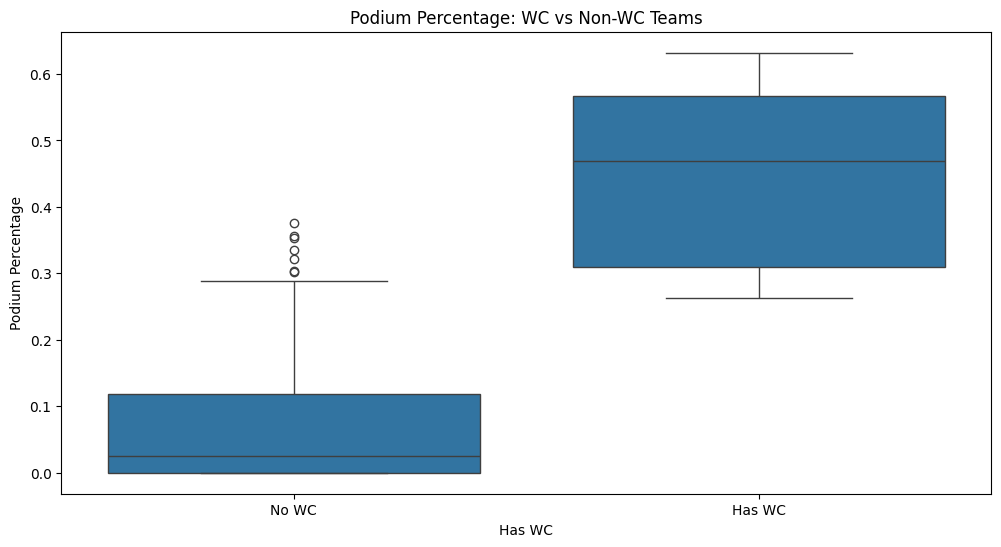

In [9]:
plt.figure(figsize=(12, 6))

# Podium Percentage comparison
sns.boxplot(x='Has WC', y='Podium Percentage', data=all_drivers)
plt.xticks([0, 1], ['No WC', 'Has WC'])
plt.title('Podium Percentage: WC vs Non-WC Teams')

#plt.tight_layout()
plt.show()

We can see that teams that have won world championships have a substantially higher podium percentage. We can observe that the median podium percentage for non world champions is lower than 0.1 where as the median for world champions is over 0.5. There is no overlap between the upper quartile of non world champions and world champions, however, we do see some outliers here where some teams have higher podium percentages but just haven't won a world championship.

Continuing, we want to see the relationship between points earned and number of grand prix (races entered)

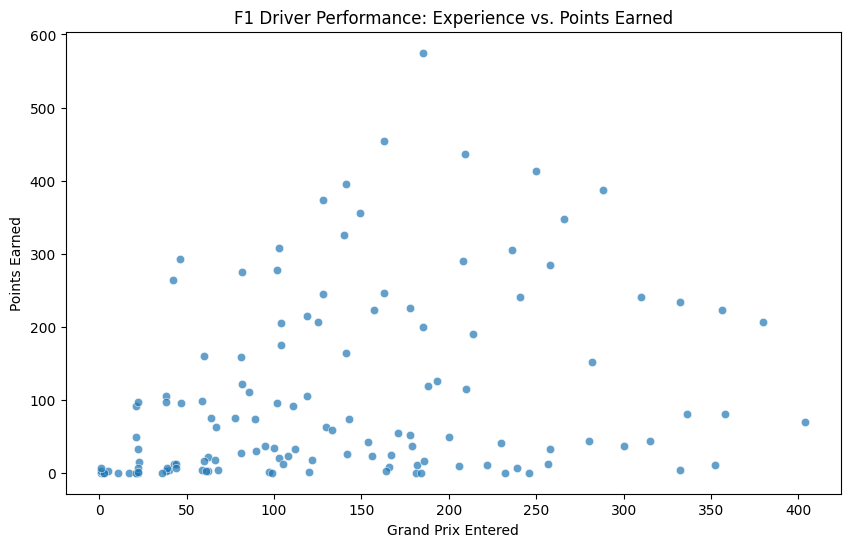

In [10]:

# Create scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_drivers_standings, x='Grands Prix Entered', y='Points_forSeason', alpha=0.7, legend = False)

# Labels and title
plt.xlabel("Grand Prix Entered")
plt.ylabel("Points Earned")
plt.title("F1 Driver Performance: Experience vs. Points Earned")

# Show plot
plt.show()

Just by looking at the visualization, there appears to be no trend between Grnad Prixed Entered and Points Earned in a Season. There is a slight positive trend in the middle of the plot but this trend dies down as the number of Grand Prixed Entered grows larger.

In [11]:
r_value, p_value = pearsonr(all_drivers["Grands Prix Entered"], all_drivers["Points"])
print(f"Pearson r: {r_value:.4f}, p-value: {p_value:.4e}")

Pearson r: 0.8056, p-value: 2.4295e-31


Here we have ran a pearson correlation test to see the correlation between the two variables. The calculated correlation coefficient is 0.2862 which is a low coefficient. This tells us there is little correlation between Grand Prix Entered and the points earned by a driver in a season.

Now we can see the point distribution across each team.

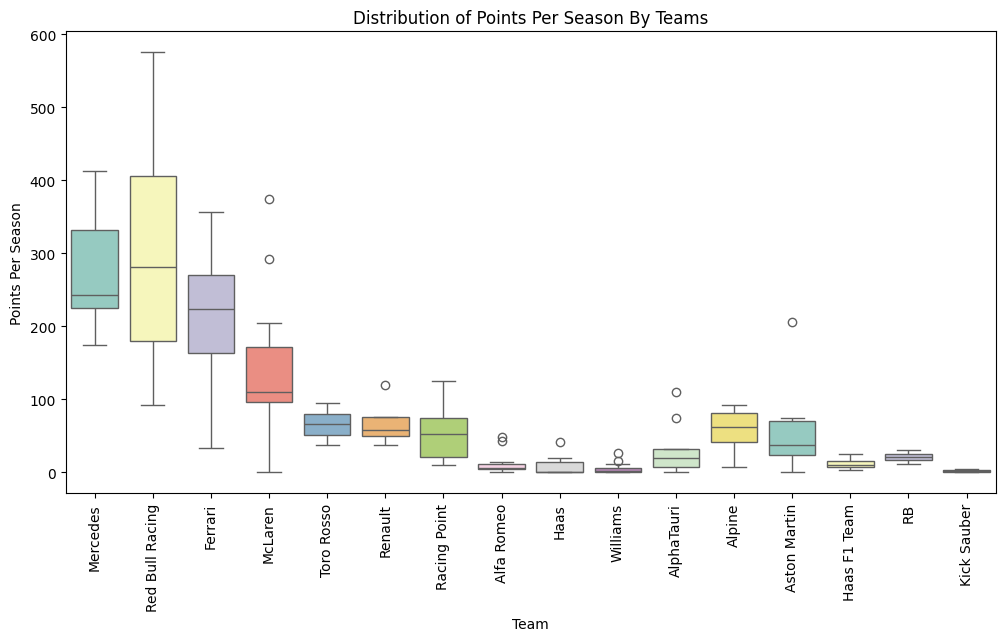

In [12]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_drivers_standings, x="Team", y="Points_forSeason", palette="Set3", hue = "Team", legend = False)
plt.xticks(rotation=90)
plt.title("Distribution of Points Per Season By Teams")
plt.xlabel("Team")
plt.ylabel("Points Per Season")
plt.show()


We can observe that Red Bull tends to be the dominant team, scoring more points on average than other teams. The next closest team is mercedes, but on average it has substantially less points that red bull does. This could show a trend of red bull being the most dominant team in this sport.

Now we want to see the podium percentage across each team.

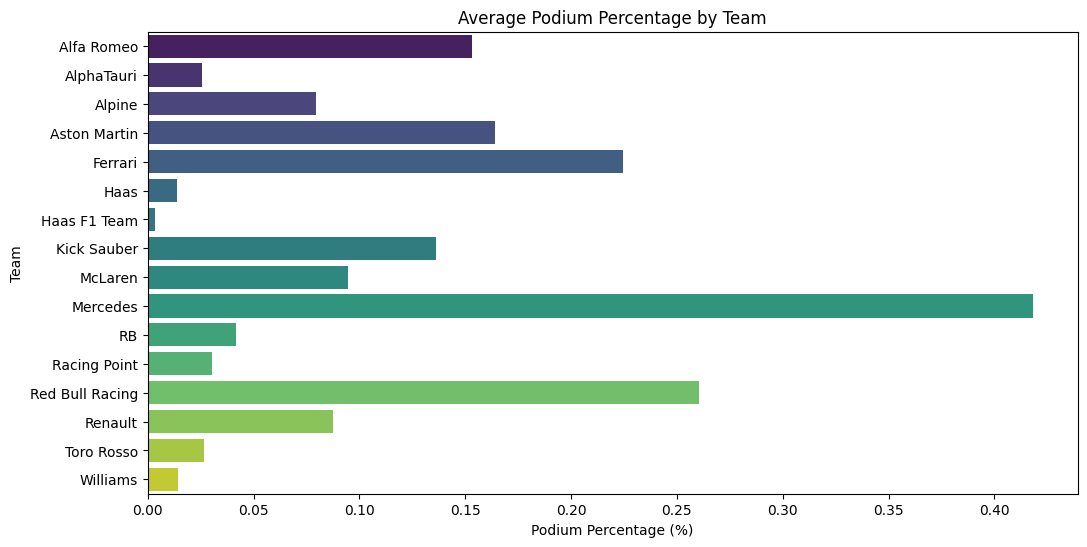

In [13]:
team_podium = all_drivers.groupby("Team")["Podium Percentage"].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=team_podium, x="Podium Percentage", y="Team", palette="viridis", hue = "Team", legend=False)
plt.title("Average Podium Percentage by Team")
plt.xlabel("Podium Percentage (%)")
plt.ylabel("Team")
plt.show()

Here we observe that Mercedes actually has a much higher average podium percentage than red bull does. This is interesting because as we saw above, red bull racing had the highest points on average. Here, Ferrari also has a close podium percentage to red bull but Ferrari generally scores significantly less points than Red Bull does as we saw in the plot above.

Now we want to see the Distribution of Points scored per Season by Driver.

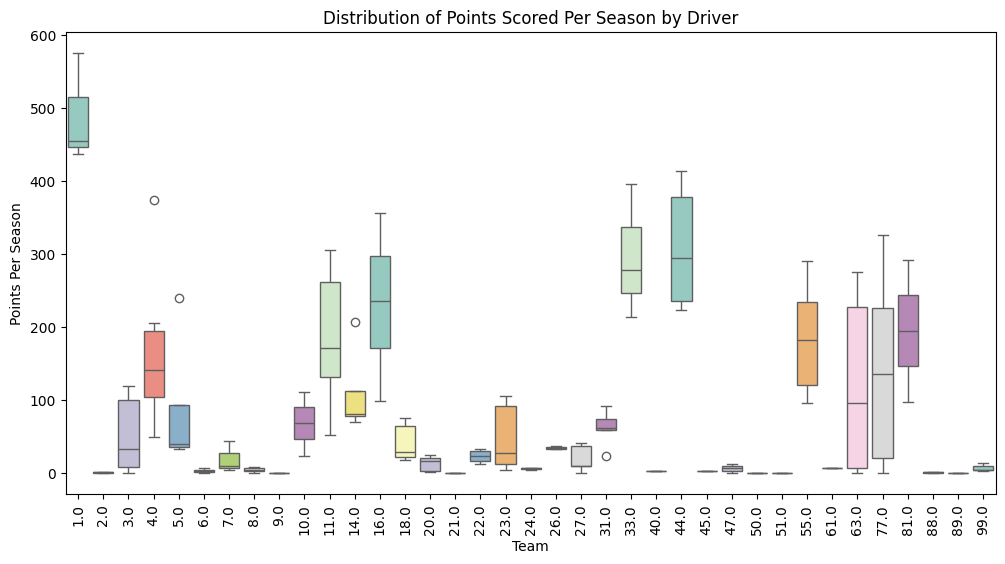

In [14]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_drivers_standings, x="Number", y="Points_forSeason", palette="Set3", hue = "Number", legend = False)
plt.xticks(rotation=90)
plt.title("Distribution of Points Scored Per Season by Driver")
plt.xlabel("Team")
plt.ylabel("Points Per Season")
plt.show()

From this visualization we can observe that number 1, 44, 33, and 16 have been the most dominant drivers in the sport since 2019. We know that 1 and 33 are the same driver due to a number switch after winning the world championship. It makes sense that 1 has the highest points for a season because the number 1 is reserved for the world champion of the sport. Some other drivers that have shown significant improvement throughout the span of our data are number 16, 63, and 77.

Now we want to see the Distribution of Points scored per Season by Country to see which country has the best drivers.

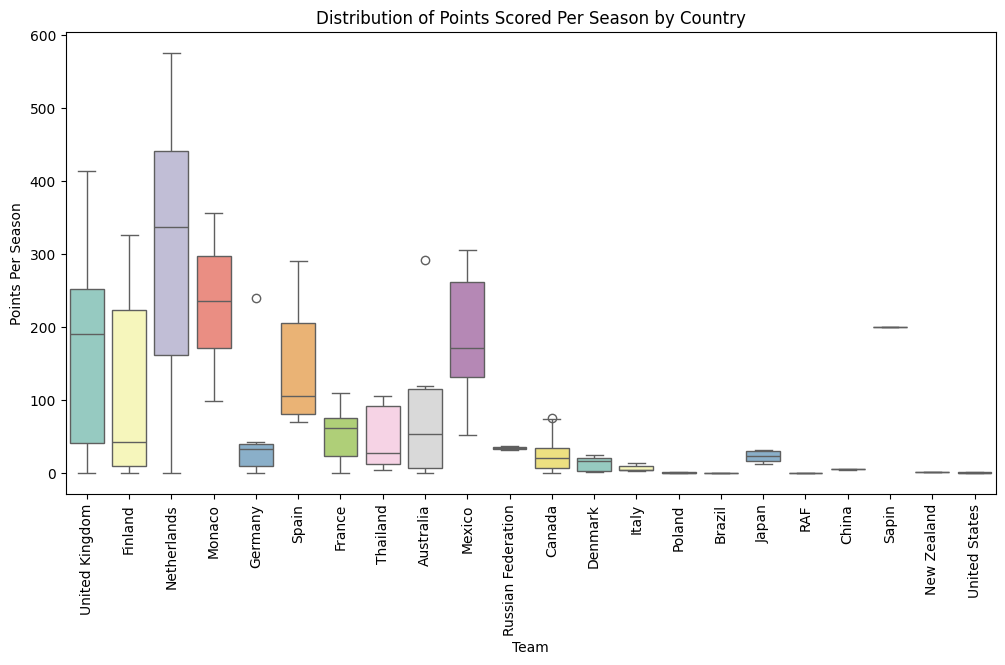

In [15]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_drivers_standings, x="Country", y="Points_forSeason", palette="Set3", hue = "Country", legend = False)
plt.xticks(rotation=90)
plt.title("Distribution of Points Scored Per Season by Country")
plt.xlabel("Team")
plt.ylabel("Points Per Season")
plt.show()

We can observe from the visualization that the Netherlands appears to be the dominant country with the best drivers. Some other notable countries are the United Kingdom, Monaco, and Mexico. Some countries that appear to be notoriously bad are the United States, New Zealand, Brazil, Poland, and RAF.

Starting K-Means Clustering to try and categorize the driver's into performance groups:

For our unsupervised Learning, we will use K-Means Clustering to categorize our drivers into different clusters based on the driver's podium percentage, their total number of points, and their historical highest grid position. We will use the K-Means function from the sklearn library. 

To select the best number of clusters, we will use the elbow method to find our optimal k clusters.


For our clustering we will use the driver's average lap time, number of pole positions, and their podium percentage to try to cluster the drivers.
We will try to find the best number of clusters using the Elbow method.

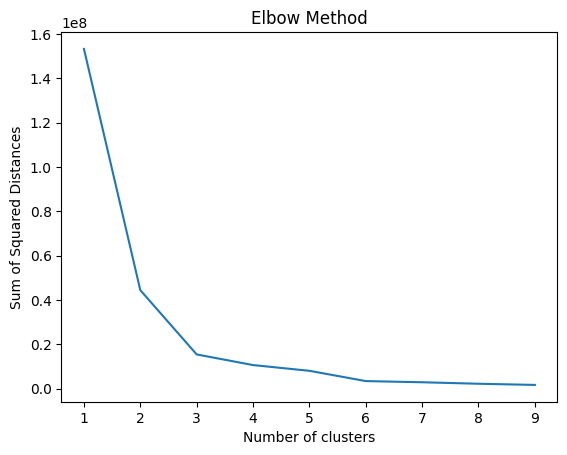

In [16]:
#we will select, from the all_drivers dataset, the variables 'Podium Percentage', 'Points', and 'Highest Grid Position'
selected_data = all_drivers[['Podium Percentage', 'Points', 'Highest Grid Position']]

#making a variable that will hold the Sum of Squared Distances 
SSD = []
#Finding the best number of cluseters from 1 to 10
for i in range(1, 10):
    #making the number of clusters in a variable called 'kmeans'
    kmeans = KMeans(n_clusters = i, max_iter = 250, random_state = 0)
    #fitting the selected data from all_drivers to our kmeans model made above.
    kmeans.fit(selected_data)
    #adding the square distance to SSD
    SSD.append(kmeans.inertia_)

#Plotting the graph for the elbow method to find the best number of clusters 
plt.plot(range(1, 10), SSD)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squared Distances')
plt.show()

Based on the Elbow graph above, we see that a number of clusters equal to 3 seems to be ideal for us. This should make sure that we do not over fit our model.

Let's see how k-means with a k = 3 will cluster our data:

In [17]:
#making a kmeans model with the best number of clusters, which is 3
best_kmeans = KMeans(n_clusters = 3, max_iter = 250, random_state = 0)
#Predicting the class of our data with the best number of clusters 
class_ = best_kmeans.fit_predict(selected_data)

#Adding a new column to all_drivers and setting our predicted classes
all_drivers['Cluster'] = class_
all_drivers.head()

,Number,Team,Country,Podiums,Points,Grands Prix Entered,World Championships,Highest Grid Position,Year,Podium Percentage,Has WC,Cluster
0,44.0,Mercedes,United Kingdom,151,3431.0,250,6,1,2019,0.604000,1,2
1,77.0,Mercedes,Finland,45,1289.0,140,0,1,2019,0.321429,0,0
2,33.0,Red Bull Racing,Netherlands,31,948.0,102,0,1,2019,0.303922,0,0
3,16.0,Ferrari,Monaco,10,303.0,42,0,1,2019,0.238095,0,1
4,5.0,Ferrari,Germany,120,2985.0,241,4,1,2019,0.497925,1,2


Here we can see our kmeans algorithm has partitioned our clusters into 3 groups. We used the variables Podium Percentage, Points, and Highest Grid Position to partition the drivers into 3 seperate classes that would allow us to see how good of a driver they are: high class, medium class, and low class driver.

To understand how our data was clustered, we will explore the data further with the clusters in mind. We ended up with 3 clusters, labeled 0, 1, and 2 respectively.

The figure below explores our drivers, their respective podium percentage, and the points are colored by class.

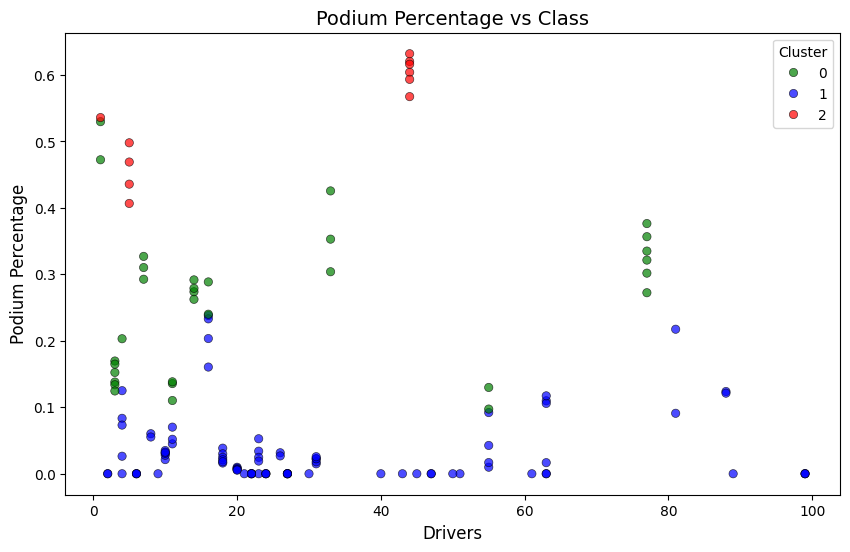

In [18]:
plt.figure(figsize=(10, 6))

all_drivers["Cluster"] = all_drivers["Cluster"].astype("category")

sns.scatterplot(data=all_drivers, x="Number", y="Podium Percentage", alpha=0.7, edgecolor="black", hue = "Cluster", palette={0: "green", 1: "blue", 2: "red"})

# Labels and title
plt.title("Podium Percentage vs Class", fontsize=14)
plt.xlabel("Drivers", fontsize=12)
plt.ylabel("Podium Percentage", fontsize=12)

# Show the plot
plt.show()

From this graph we can see that a cluster value of 0 corresponds to the lower class (color blue), 1 corresponds to the middle class (color green), 2 corresponds to the higher class (color red).  We also notice that the number of drivers in each group decreases as we ge up in podium percentage. We can clearly see that around a 0 to 0.1 podium percentage, the majority of class 1 points are distributed. As we move up to a podium percentage 0.2 to around 0.4, we see a majority of the class 0 drivers. Lastly, with the fewest number of drivers in its class, class 2 contians drivers that have podium percentage of around 0.4 and higher.

Now, we will look at the relationship between driver and country, again with respect to their class as the coloring basis.

<Figure size 1200x600 with 0 Axes>

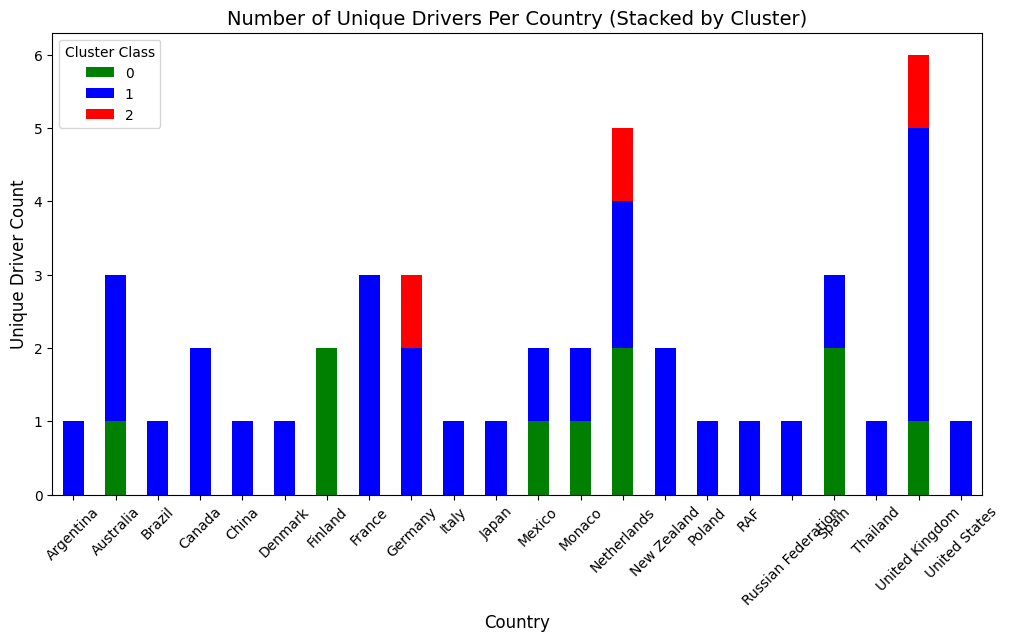

In [19]:
# data cleaning to remove typo
cleaned_all_drivers = all_drivers[all_drivers["Country"] != "Sapin"]
# Step 1: Remove duplicates only when both "Number" and "Cluster" match
unique_drivers = cleaned_all_drivers.drop_duplicates(subset=["Number", "Cluster"])

# Step 2: Count unique drivers per country and per cluster
country_cluster_counts = unique_drivers.groupby(["Country", "Cluster"]).size().unstack(fill_value=0)

# Step 3: Plot stacked bar chart
plt.figure(figsize=(12, 6))
colors = {0: "green", 1: "blue", 2: "red"}  # Custom color mapping
country_cluster_counts.plot(kind="bar", stacked=True, 
                            color=[colors[c] for c in country_cluster_counts.columns], 
                            figsize=(12, 6))

# Labels and title
plt.title("Number of Unique Drivers Per Country (Stacked by Cluster)", fontsize=14)
plt.xlabel("Country", fontsize=12)
plt.ylabel("Unique Driver Count", fontsize=12)
plt.xticks(rotation=45)  # Rotate for readability
plt.legend(title="Cluster Class")

# Show the plot
plt.show()

This here shows the distribtion of driver class across each country. We made sure to remove any duplicates where drivers were in the same class across multiple years. However, we included when the same driver appeared in multiple classes over different years. We can see that only Germany, Netherlands, and the United Kingdom has produced high class drivers. We also see that Finland has only ever produced low class drivers. Some other countries that produced middle class drivers are Australia, Canada, France, United Kingdom, and New Zealand. 

Lastly, we will also explore the distribution of drivers across teams to see if there are any interesting findings here.

<Figure size 1200x600 with 0 Axes>

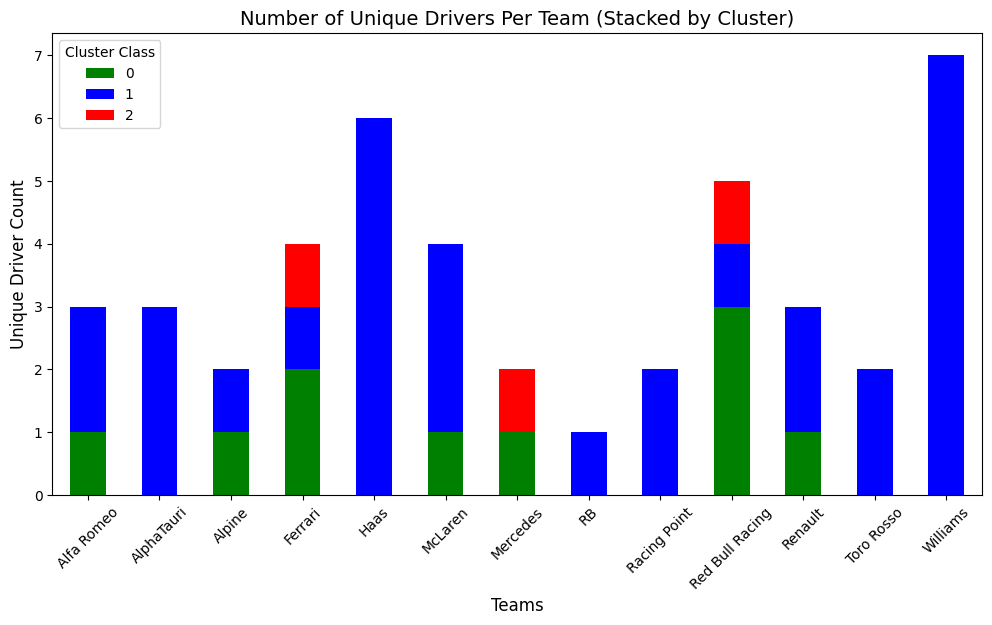

In [20]:
# Step 2: Count unique drivers per country and per cluster
team_cluster_counts = unique_drivers.groupby(["Team", "Cluster"]).size().unstack(fill_value=0)

# Step 3: Plot stacked bar chart
plt.figure(figsize=(12, 6))
colors = {0: "green", 1: "blue", 2: "red"}  # Custom color mapping
team_cluster_counts.plot(kind="bar", stacked=True, 
                            color=[colors[c] for c in team_cluster_counts.columns], 
                            figsize=(12, 6))

# Labels and title
plt.title("Number of Unique Drivers Per Team (Stacked by Cluster)", fontsize=14)
plt.xlabel("Teams", fontsize=12)
plt.ylabel("Unique Driver Count", fontsize=12)
plt.xticks(rotation=45)  # Rotate for readability
plt.legend(title="Cluster Class")

# Show the plot
plt.show()

This graph shows the distribution of classes across the different teams in Formula 1. We made sure to remove any duplicates where drivers were in the same class across multiple years. However, we included when the same driver appeared in multiple classes over different years. Here we see that Williams and Haas have had the most drivers in our 6 year time frame for our data. They have also consistely produced middle class drivers, and have not produced any low class drivers. Red Bull Racing, has a high class driver but it also has the most low class drivers.


Lets see how much our variables influence the class prediction of our k-means model by looking at the correlation between class and each variable that we used to classify our drivers.

In [21]:
#Creating some sub-dataframes for 'Podium Percentage', 'Points', 'Highest Grid Position'
podium_to_class = all_drivers[['Podium Percentage', 'Cluster']]
prev_points_to_class = all_drivers[['Points', 'Cluster']]
grid_pos__to_class = all_drivers[['Highest Grid Position', 'Cluster']]

print(f"The correlation between Podium Percentage: {podium_to_class.corr().iloc[1,0]}")
print(f"The correlation between Previous Points Percentage: {prev_points_to_class.corr().iloc[1,0]}")
print(f"The correlation between Highest Grid Position Percentage: {grid_pos__to_class.corr().iloc[1,0]}")

The correlation between Podium Percentage: 0.03535578966409758
The correlation between Previous Points Percentage: 0.10583439063861579
The correlation between Highest Grid Position Percentage: 0.18425136924366953


Next we wanted to see how lap times varied by each track, so we took the fastest lap times from each team for each track and compared them.
As we see, out of the variables we used to classify our points, it seems that the variable 'Highest Grid Position' has about an 18.42% correlation with the classes asigned. It is followed by their total career points until that season (~10.58%), and lastly, their podium percentage (~3.54%).

Based on this, we can say that the variables we chose have a positive correlation, however a mild one, with the strongest correlation being a somewhate positive correlation, and with the smallest correlation being a pretty weak positive correlation.

**KNN Regression -- Supervised Learning**

Now let's use K-Nearest-Neighbors to try and predict the driver's standings at the end of a season.

We will use multiple variables to help predict the standings. However, we want to modify some of our variables first. We will start by only selecting races that are in all of our years for consistency. 

In [22]:
unique_drivers = all_drivers['Number'].unique() 
unique_race_drivers = all_races['No'].unique()

#Making sure unique drivers only has the same drivers as in unique race drivers
    #this is done to ensure that any driver that may have only been in one race, but did not finish does not appear in our data
unique_drivers = all_drivers[all_drivers['Number'].isin(unique_race_drivers)]

races_2019 = (all_races[all_races['Year'] == 2019])['Track'].unique()
races_2020 = (all_races[all_races['Year'] == 2020])['Track'].unique()
races_2021 = (all_races[all_races['Year'] == 2021])['Track'].unique()
races_2022 = (all_races[all_races['Year'] == 2022])['Track'].unique()
races_2023 = (all_races[all_races['Year'] == 2023])['Track'].unique()
races_2024 = (all_races[all_races['Year'] == 2024])['Track'].unique()

#Listing all of the races that are in all of our years.
consistent_races = np.array(["Australia", "Azerbaijan", "Spain", "Italy", "Great Britain", "Hungary", "Belgium", "Monaco", "Japan", "United States", "Brazil", "Abu Dhabi"])

#Knn Races will only contain only the information from all_races that is on the tracks in consistent races
knn_races = all_races[all_races['Track'].isin(consistent_races)]
knn_races

,Track,Position,No,Team,Starting Grid,Points,Fastest Lap,Year,Time/Retired,Net Position,Time (seconds)
0,Australia,1,77,Mercedes,2,26.0,Yes,2019,1:25:27.325,1,5127.325
1,Australia,2,44,Mercedes,1,18.0,No,2019,+20.886,-1,5148.211
2,Australia,3,33,Red Bull Racing Honda,4,15.0,No,2019,+22.520,1,5149.845
3,Australia,4,5,Ferrari,3,12.0,No,2019,+57.109,-1,5184.434
4,Australia,5,16,Ferrari,5,10.0,No,2019,+58.230,0,5185.555
...,...,...,...,...,...,...,...,...,...,...,...
471,Abu Dhabi,13,24,Kick Sauber Ferrari,15,0.0,No,2024,+1 lap,2,5217.325
472,Abu Dhabi,14,18,Aston Martin Aramco Mercedes,13,0.0,No,2024,+1 lap,-1,5217.325
473,Abu Dhabi,15,61,Alpine Renault,17,0.0,No,2024,+1 lap,2,5217.325
474,Abu Dhabi,16,20,Haas Ferrari,14,0.0,Yes,2024,+1 lap,-2,5217.325


Now, after separating the consistent races, we will create a new column that will have the average fastest lap for each driver.

In [23]:

unique_drivers = unique_drivers
unique_drivers["Avg Fastest Lap"] = 0

xval = (knn_races[knn_races['Year'] == 2019])
y = list((xval[ xval['No'] == 44.0])["Fastest Lap"])

years = [2019, 2020, 2021, 2022, 2023, 2024]
driverNumbers = list(unique_drivers.iloc[:,0])

fastestLapSum = 0
for k in driverNumbers:
    for j in years:
        xval = (knn_races[knn_races['Year'] == j])
        y = list((xval[ xval['No'] == k])["Fastest Lap"])
        for i in range(0,len(y)):
            if(y[i] == "Yes"):
                fastestLapSum += 1   
        for m in range(len(unique_drivers)):
            if((unique_drivers.iloc[m,0] == k) & (unique_drivers.iloc[m,8] == j)):
                unique_drivers.iloc[m,12] = fastestLapSum/len(xval)
        fastestLapSum = 0

print(unique_drivers.iloc[:,12])

0     0.023364
1     0.004673
2     0.004673
3     0.009346
4     0.004673
        ...   
19    0.000000
20    0.000000
21    0.000000
22    0.000000
23    0.000000
Name: Avg Fastest Lap, Length: 132, dtype: float64


The output above shows us some of our average lap times, including some of the first and some of the last results in our data.
We will also create a new variable called "Avg Net Position" which is contain the average net position of the drivers acrosss the years avaliable in our data.

In [24]:
unique_drivers = unique_drivers
unique_drivers["Avg Net Position"] = 0
sumNetPosition = 0

xval = (knn_races[knn_races['Year'] == 2019])
y = list((xval[ xval['No'] == 44.0])["Net Position"])

years = [2019, 2020, 2021, 2022, 2023, 2024]
driverNumbers = list(unique_drivers.iloc[:,0])

for k in driverNumbers:
    for j in years:
        xval = (knn_races[knn_races['Year'] == j])
        y = list((xval[ xval['No'] == k])["Net Position"])
        for i in range(0,len(y)):
            sumNetPosition += y[i]  
        for m in range(len(unique_drivers)):
            if((unique_drivers.iloc[m,0] == k) & (unique_drivers.iloc[m,8] == j)):
                unique_drivers.iloc[m,13] = sumNetPosition/len(xval)
        sumNetPosition = 0
print(unique_drivers.iloc[:,13])


0     0.014019
1     0.056075
2     0.046729
3    -0.023364
4    -0.168224
        ...   
19    0.060748
20    0.004673
21   -0.028037
22    0.000000
23    0.009346
Name: Avg Net Position, Length: 132, dtype: float64


Now that we have created our variabels, we can move onto creating and training our KNN Regression model.

We will use a 70-30 split for our data, wehere 70% of the data will be used to train the mdoel and we will use the remaining 30% to test it.
We use the variables "Avg Net Position", "Avg Fastest Lap", "Cluster", "Podium Percentage", "Has WC", "Points" from our unique_drivers data and we will be trying to predict the driver standings as found in the "Position" variables in the satandings data.

However, before we can use our model, we need to determine the optimal number of neighbors to compare to. To do this, we will chose the number of neighbors for which the model with the highest acuracy.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(unique_drivers[["Avg Net Position", "Avg Fastest Lap", "Cluster", "Podium Percentage", "Has WC", "Points"]], standings[["Position"]].fillna(0), test_size=0.3, random_state=0)

accuracy = []

for k in range(1, 21):
    knn_model = KNeighborsRegressor(n_neighbors=k)
    knn_model.fit(X_train, y_train)
    print(f'Score for k={k}: {knn_model.score(X_test, y_test)}')
    accuracy.append(knn_model.score(X_test, y_test))


Score for k=1: 0.38325417994925515
Score for k=2: 0.5836315138897925
Score for k=3: 0.6298946790131489
Score for k=4: 0.556998568733329
Score for k=5: 0.4886734760262833
Score for k=6: 0.4351195252242679
Score for k=7: 0.47405596810319983
Score for k=8: 0.47305396525925447
Score for k=9: 0.4545203369179255
Score for k=10: 0.42321904885823947
Score for k=11: 0.43530561737220097
Score for k=12: 0.4333485134343895
Score for k=13: 0.43385665544776364
Score for k=14: 0.4426026216875404
Score for k=15: 0.4341292043458461
Score for k=16: 0.40852498210916666
Score for k=17: 0.4060243315334071
Score for k=18: 0.40067314511614394
Score for k=19: 0.3908646548317145
Score for k=20: 0.36292043458460754


To further look into how our model performes with a different k neighbors, we will plot our accuracy to the number of neighbors.

Text(0, 0.5, 'Accuracy')

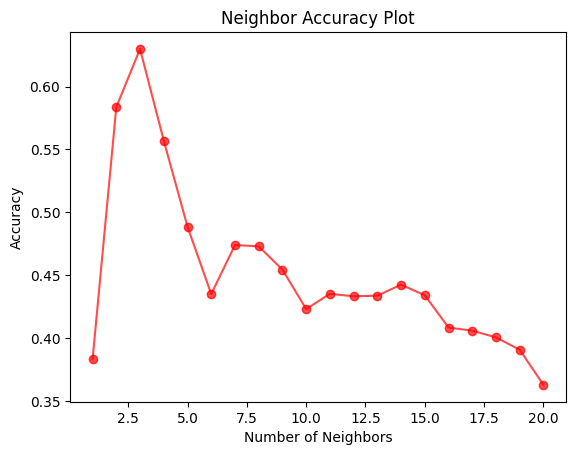

In [26]:
cluster_accuracy = np.column_stack((accuracy, np.arange(1, 21)))
plt.plot(cluster_accuracy[:, 1], cluster_accuracy[:, 0], marker='o', color='r', linestyle='-', alpha=0.7)

plt.title('Neighbor Accuracy Plot')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')

From the graph above, we can see that for 3 neighbors, our model performes the best with around 63% accuracy, and afterwards we start losing accuracy relatively-consistently. This tells us that we want to use 3 neighbors for our model so that we get the optimal model we can. 

Now that we have our model, lets see if it can accurately predict the top three drivers from the 2024 race year accurately. The correct standings, in order, would be Max Verstappen, Lando Norris, and Charles Leclerc.

In [27]:
standings_2024 = standings[standings["Year"] == 2024]
X_pred_vals_2024 = unique_drivers[unique_drivers["Year"] == 2024]

max_2024 = X_pred_vals_2024[X_pred_vals_2024["Number"] == 1]
norris_2024 = X_pred_vals_2024[X_pred_vals_2024["Number"] == 4]
leclerc_2024 = X_pred_vals_2024[X_pred_vals_2024["Number"] == 16]

knn_opt_model = KNeighborsRegressor(n_neighbors=3)
knn_opt_model.fit(X_train, y_train)

max_pred = knn_opt_model.predict(max_2024[["Avg Net Position", "Avg Fastest Lap", "Cluster", "Podium Percentage", "Has WC", "Points"]])
norris_pred = knn_opt_model.predict(norris_2024[["Avg Net Position", "Avg Fastest Lap", "Cluster", "Podium Percentage", "Has WC", "Points"]])
leclerc_pred = knn_opt_model.predict(leclerc_2024[["Avg Net Position", "Avg Fastest Lap", "Cluster", "Podium Percentage", "Has WC", "Points"]])

print("Prediction for Max Verstappen:",  max_pred.item())
print("Prediction for Lando Norris:",  norris_pred.item())
print("Prediction for Charles Leclerc:",  leclerc_pred.item())

true_max = standings_2024[standings_2024["Number"] == 1]
print("\nActual for Max Verstappen:", true_max["Position"].iloc[0])

true_norris = standings_2024[standings_2024["Number"] == 4]
print("Actual for Lando Norris:",true_norris["Position"].iloc[0])

true_leclerc = standings_2024[standings_2024["Number"] == 16]
print("Actual for Charles Leclerc:",true_leclerc["Position"].iloc[0])


Prediction for Max Verstappen: 10.0
Prediction for Lando Norris: 5.333333333333333
Prediction for Charles Leclerc: 2.3333333333333335

Actual for Max Verstappen: 1
Actual for Lando Norris: 2
Actual for Charles Leclerc: 3


From the output above, we see that our model is definitely not perfect. It predicted that Max would end up finishing in 10th place, Lando finishing around 5th, and Charles leading the group by ending in about 2nd place. Its closest prediction was Charles Leclerc, who actually finished in 3rd place that year, and its worst prediction would be Max Verstappen, who was predicted to be nine places away from his actual standings.

From the results we can definitely say that our model is not perfect as it does not predict accurately enough to be relied on. However, it can likely be improved with more data or maybe some different variables.

**CONCLUSION:**

Throughout the project, we have explored our F1 data, explored relationships between variables during our EDA, trained and optimized a K-Means clustering model, and used all of our data manipulation and knowledge to create, optimize, and run a K-Nearest-Neighbors regression model to try and predict F1 driver's standings.

We saw that our KNN regression model only got to around 63% accuracy after several tests to determine our best model. This means that arounrd 63% of our data will be correctly predicted into the right spot on the driver's standings.

Overall, we have learned that it is possible to create a KNN Regression model that will predict the drivers standings, however, with the data and resources we had, we were unable to create a better model. This does not mean, however, that a better model cannot be created. We believe that with more data, and some differnet models, such as gradient descent with linear regression, it is possible for us to create a better predictive model that will more accurately predict the drivers standings.


**Contributions:**

Dmitry Sorokin: (30%)
    - K-means Clustering
    - KNN Regression: Model and Analysis
    - Initial Data Cleaning and Pre-Processing
    - Presentation Cleaning
    - Proposal Document

Kyle Chahal: (30%)
    - KNN Feature Selection and Creation 
    - Video Editing
    - Presentation
    - Proposal Document
    
Justin Shiu: (30%)
    - EDA
    - K-means Analysis
    - Project Presentation
    - Final Project Cleaning and Touch-Up

Justin An: (10%)
    - Project Slides